# Single label Classifier - AF Detection

Using the dataset provided by the 2020 Physionet Challenge we've developed an Atrial Fibrilation Detector trained to identify AF diagnosed patients from a dataset containing patients with different pathologies like: PAC, RBBB, I-AVB, PVC, LBBB, STD, STE and healthy individuals.

Although data from 12-lead ECG was provided, for this first analysis we've only used the lead 2 data and we've processed the signals in order to create a dataframe consisting of features we believe will help us classify.


In [1]:
import sys
import os
import subprocess
from urllib.parse import urlparse

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from IPython.display import display

from scipy.cluster import hierarchy as hc
from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import mlflow
import mlflow.sklearn

%matplotlib inline
import plotly.express as px
import seaborn as sns

In [2]:
experiment_id = mlflow.set_experiment('features_definitivas')

In [3]:
subprocess.run('rm -rf mlruns/.trash/*', shell=True, check=True)

CompletedProcess(args='rm -rf mlruns/.trash/*', returncode=0)

In [4]:
lead = 'HRV-lead2'
df_raw = pd.read_feather('datasets/phys-raw-lead2-HRV-eda')
df_raw.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_HTI', 'var_P_time', 'var_P_peaks', 'age', 'label'],
      dtype='object')

### Data checks

In [5]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,Non-AF
count,6201.000000,6201.000000
mean,0.168037,0.831963
std,0.373930,0.373930
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


## Split between Train and Validation Datasets

### Training (60%) - Validation (20%) - Evaluation (20%)

In [6]:
y = df_raw['label'].copy()
X = df_raw.drop('label', axis=1)
X_train, X_test, ytrain, ytest = train_test_split(X, y, test_size=0.4, random_state=42)

X_val, X_eval, yval, yeval = train_test_split(X_test, ytest, test_size=0.5, random_state=42)

ytrain[:5]

2770    Non-AF
3790    Non-AF
2277        AF
1401    Non-AF
6179    Non-AF
Name: label, dtype: object

### Label encoding
'AF' as 1 and 'Non-AF' as 0

In [7]:
y_eval = label_binarize(yeval, classes=['Non-AF', 'AF'])
y_val = label_binarize(yval, classes=['Non-AF', 'AF'])
y_train = label_binarize(ytrain, classes=['Non-AF', 'AF'])
y_train[:5]

array([[0],
       [0],
       [1],
       [0],
       [0]])

## Evaluation Metrics

This are the evaluation metrics we are actually interested in.

We calculate the geometric mean between the AUC ROC curve in the training set (with cross validation) and the validation set to determine the best model.

In [8]:
res = pd.DataFrame({'model':[], 'geometric mean':[], 'auc train (cv)':[], 'auc val':[], 'f2 val':[], 'sensitivity val':[], 'precision val':[]})

## Model Experiments

In [9]:
models = {
        'LDA': LinearDiscriminantAnalysis(),
        'Perceptron': MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(3, 3), random_state=42, max_iter=100000),
        'Logistic Regression': LogisticRegression(max_iter = 2000, n_jobs = 4, random_state=42),
        'Random Forest': RandomForestClassifier(n_jobs = 4, random_state=42, class_weight={1: 10}),
        'SVC': SVC(random_state=42, class_weight={1: 10}),
        'KNNeighbors': KNeighborsClassifier(n_jobs = 4)
}

#scorer = make_scorer(f1_score, pos_label='AF')

In [10]:
for name, model in models.items():
    
    # Model training with cross validation
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=4)
    model.fit(X_train, y_train.ravel())
    
    f2 = round(fbeta_score(y_val, model.predict(X_val), beta=2), 3)
    roc = round(roc_auc_score(y_val, model.predict(X_val)), 3)
    recall = round(recall_score(y_val, model.predict(X_val)), 3)
    precision = round(precision_score(y_val, model.predict(X_val)), 3)
    
    geometric = round((scores.mean() + roc) / 2, 3)
    
    # Save the results to a dataframe
    res = res.append({'model': f"{name}", 'auc train (cv)': round(scores.mean(),3), 'geometric mean': geometric, 'auc val': roc, 'f2 val': f2, 'sensitivity val': recall, 'precision val': precision}, ignore_index=True)
    
    # Experiment Tracking
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("model", f"{name}")
        mlflow.log_param("features", "None")
        mlflow.log_param("lead", lead)
        mlflow.log_param("columns", list(X.columns))
        mlflow.log_param("number columns", len(list(X_train.columns)))
        mlflow.log_metric("auc", scores.mean())
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry
        if tracking_url_type_store != "file":

            mlflow.sklearn.log_model(model, "model", registered_model_name="AF_Classifier")
        
        else:
            
            mlflow.sklearn.log_model(model, "model")

In [11]:
res.sort_values('geometric mean', ascending=False)

,model,geometric mean,auc train (cv),auc val,f2 val,sensitivity val,precision val
0,LDA,0.950,0.972,0.929,0.886,0.915,0.788
3,Random Forest,0.946,0.981,0.911,0.855,0.851,0.870
2,Logistic Regression,0.931,0.974,0.888,0.818,0.817,0.821
1,Perceptron,0.927,0.945,0.909,0.857,0.898,0.725
4,SVC,0.903,0.927,0.879,0.826,0.974,0.513
5,KNNeighbors,0.864,0.924,0.804,0.676,0.664,0.732


### Let's try some Scalers

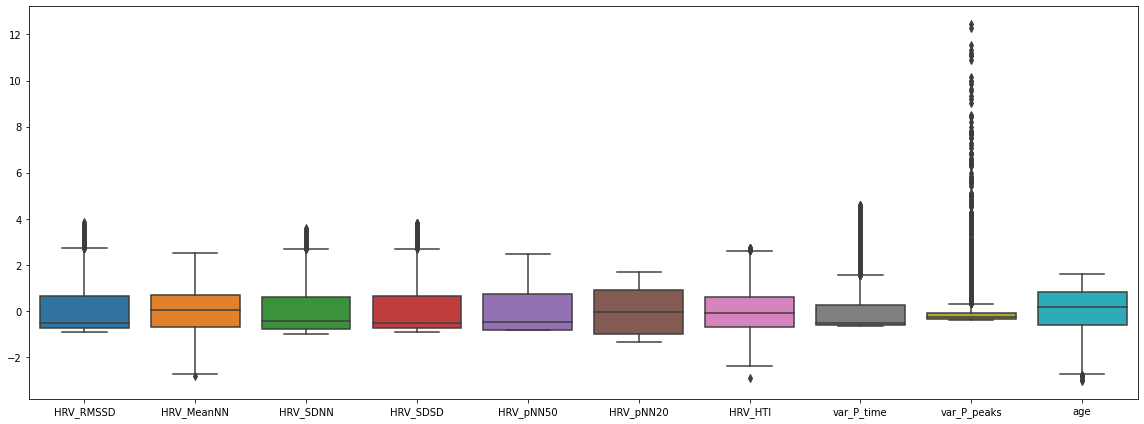

In [12]:
scal = StandardScaler()
df_normal = scal.fit_transform(df_raw.drop('label', axis=1))
cols = df_raw.columns
cols = cols.drop('label')
df_normal = pd.DataFrame(df_normal, columns=cols)

plt.figure(figsize=(16,6))
sns.boxplot(data=df_normal)
plt.tight_layout()
plt.show()

In [13]:
scal = StandardScaler()
xtrain_scal = scal.fit_transform(X_train)
xval_scal = scal.transform(X_val)

In [14]:
for name, model in models.items():
    scores = cross_val_score(model, xtrain_scal, y_train, cv=10, scoring='roc_auc', n_jobs=4)
    model.fit(xtrain_scal, y_train.ravel())
    
    f2 = round(fbeta_score(y_val, model.predict(xval_scal), beta=2), 3)
    roc = round(roc_auc_score(y_val, model.predict(xval_scal)), 3)
    recall = round(recall_score(y_val, model.predict(xval_scal)), 3)
    precision = round(precision_score(y_val, model.predict(xval_scal)), 3)
    
    geometric = round((scores.mean() + roc) / 2, 3)
    
    res = res.append({'model': f"{name} Scal", 'auc train (cv)': round(scores.mean(),3), 'geometric mean': geometric, 'auc val': roc, 'f2 val': f2, 'sensitivity val': recall, 'precision val': precision}, ignore_index=True)
    
    # Experiment Tracking
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("model", f"{name}")
        mlflow.log_param("features", "Standard Scaler")
        mlflow.log_param("lead", lead)
        mlflow.log_param("columns", list(X.columns))
        mlflow.log_param("number columns", len(list(X_train.columns)))
        mlflow.log_metric("auc", scores.mean())
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        if tracking_url_type_store != "file":

            mlflow.sklearn.log_model(model, "model", registered_model_name="AF_Classifier")
        
        else:
            
            mlflow.sklearn.log_model(model, "model")

In [15]:
res.sort_values('geometric mean', ascending=False)

,model,geometric mean,auc train (cv),auc val,f2 val,sensitivity val,precision val
10,SVC Scal,0.958,0.977,0.940,0.906,0.966,0.725
0,LDA,0.950,0.972,0.929,0.886,0.915,0.788
6,LDA Scal,0.950,0.972,0.929,0.886,0.915,0.788
7,Perceptron Scal,0.947,0.974,0.920,0.871,0.885,0.819
9,Random Forest Scal,0.947,0.981,0.913,0.858,0.855,0.870
3,Random Forest,0.946,0.981,0.911,0.855,0.851,0.870
11,KNNeighbors Scal,0.942,0.966,0.918,0.869,0.889,0.795
8,Logistic Regression Scal,0.933,0.973,0.894,0.828,0.826,0.836
2,Logistic Regression,0.931,0.974,0.888,0.818,0.817,0.821
1,Perceptron,0.927,0.945,0.909,0.857,0.898,0.725


### Principal Component Analysis

In [16]:
n_comps = 5  # +90% explained variance

pca = PCA(n_components = n_comps)

train_pca = pca.fit_transform(xtrain_scal)

val_pca = pca.transform(xval_scal)

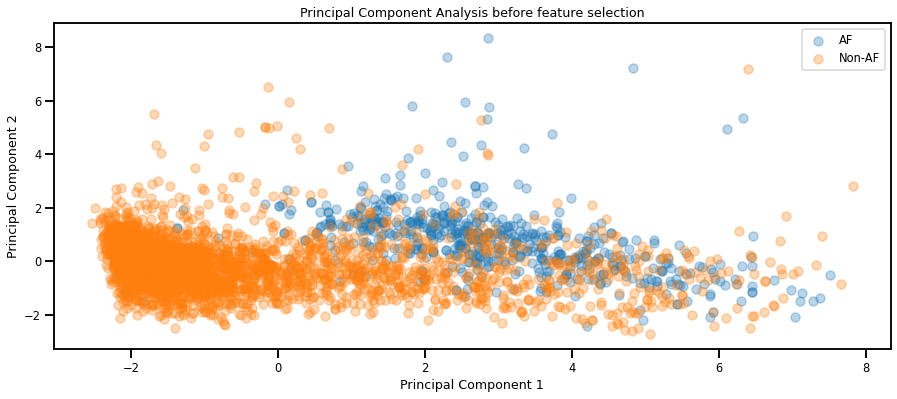

In [17]:
xpca = pd.DataFrame(train_pca)

sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))
plt.scatter(xpca.loc[(y_train == 1).ravel(),0],xpca.loc[(y_train == 1).ravel(),1], alpha = 0.3, label = 'AF')
plt.scatter(xpca.loc[(y_train == 0).ravel(),0],xpca.loc[(y_train == 0).ravel(),1], alpha = 0.3, label = 'Non-AF')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

In [18]:
for name, model in models.items():
    scores = cross_val_score(model, train_pca, y_train, cv=10, scoring='roc_auc', n_jobs=4)
    
    model.fit(train_pca, y_train.ravel())
    
    f2 = round(fbeta_score(y_val, model.predict(val_pca), beta=2), 3)
    roc = round(roc_auc_score(y_val, model.predict(val_pca)), 3)
    recall = round(recall_score(y_val, model.predict(val_pca)), 3)
    precision = round(precision_score(y_val, model.predict(val_pca)), 3)
    
    geometric = round((scores.mean() + roc) / 2, 3)
    
    res = res.append({'model': f"{name} PCA", 'auc train (cv)': round(scores.mean(),3), 'geometric mean': geometric, 'auc val': roc, 'f2 val': f2, 'sensitivity val': recall, 'precision val': precision}, ignore_index=True)
    
    # Experiment Tracking
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param("model", f"{name}")
        mlflow.log_param("features", "PCA")
        mlflow.log_param("lead", lead)
        mlflow.log_param("columns", list(X.columns))
        mlflow.log_param("number columns", len(list(X_train.columns)))
        mlflow.log_metric("auc", scores.mean())
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        if tracking_url_type_store != "file":

            mlflow.sklearn.log_model(model, "model", registered_model_name="AF_Classifier")
        
        else:
            
            mlflow.sklearn.log_model(model, "model")

In [19]:
res.sort_values('geometric mean', ascending=False)

,model,geometric mean,auc train (cv),auc val,f2 val,sensitivity val,precision val
10,SVC Scal,0.958,0.977,0.940,0.906,0.966,0.725
0,LDA,0.950,0.972,0.929,0.886,0.915,0.788
6,LDA Scal,0.950,0.972,0.929,0.886,0.915,0.788
16,SVC PCA,0.948,0.964,0.932,0.895,0.970,0.683
7,Perceptron Scal,0.947,0.974,0.920,0.871,0.885,0.819
9,Random Forest Scal,0.947,0.981,0.913,0.858,0.855,0.870
3,Random Forest,0.946,0.981,0.911,0.855,0.851,0.870
11,KNNeighbors Scal,0.942,0.966,0.918,0.869,0.889,0.795
8,Logistic Regression Scal,0.933,0.973,0.894,0.828,0.826,0.836
2,Logistic Regression,0.931,0.974,0.888,0.818,0.817,0.821


Let's evaluate the best two models

In [20]:
# Let's join our training and validation set to re-train the model

x_retrain = pd.concat([X_train, X_val])

my_list = map(lambda x: x[0], y_train)
ser1 = pd.Series(my_list)

my_list = map(lambda x: x[0], y_val)
ser2 = pd.Series(my_list)

y_retrain = pd.concat([ytrain, yval])

y_retrain = label_binarize(y_retrain, classes=['Non-AF', 'AF'])

scal = StandardScaler()
x_retrain_scal = scal.fit_transform(x_retrain)
x_eval_scal = scal.transform(X_eval)

In [27]:
models['SVC'].fit(x_retrain_scal, np.ravel(y_retrain))

eval_res = pd.DataFrame({'model': [], 'auc eval':[], 'f2 eval':[]})

roc = round(roc_auc_score(y_eval, models['SVC'].predict(x_eval_scal)), 3)
f2 = round(fbeta_score(y_eval, models['SVC'].predict(x_eval_scal), beta=2), 3)

eval_res = eval_res.append({'model': 'SVC Scal', 'auc eval': roc, 'f2 eval': f2}, ignore_index=True)

In [28]:
models['LDA'].fit(x_retrain, np.ravel(y_retrain))

roc = round(roc_auc_score(y_eval, models['LDA'].predict(X_eval)), 3)
f2 = round(fbeta_score(y_eval, models['LDA'].predict(X_eval), beta=2), 3)

eval_res = eval_res.append({'model': 'LDA', 'auc eval': roc, 'f2 eval': f2}, ignore_index=True)

In [29]:
eval_res

,model,auc eval,f2 eval
0,SVC Scal,0.944,0.904
1,LDA,0.936,0.893
